# meets


Our first example of a concept defined by a universal mapping property is a meet respectively meet.

The first step is our Catlab imports

In [1]:
using Core: GeneratedFunctionStub
using Test

using Catlab, Catlab.Theories, Catlab.CategoricalAlgebra, Catlab.CategoricalAlgebra.FinSets
using Catlab.Present
using Catlab.Graphics
using Catlab.Graphics.Graphviz

import Catlab.Theories: compose
using DataStructures

# Defining some basic preorders

In [2]:
@present P(FreeSchema) begin
  (a₁,a₂,a₃,a₄)::Ob
  f::Hom(a₁, a₂)
  g::Hom(a₁, a₃)
  h::Hom(a₂, a₄)
  k::Hom(a₃, a₄)
end

Presentation{Schema, Symbol}(Catlab.Theories.FreeSchema, (Ob = Catlab.Theories.FreeSchema.Ob{:generator}[a₁, a₂, a₃, a₄], Hom = Catlab.Theories.FreeSchema.Hom{:generator}[f, g, h, k], AttrType = Catlab.Theories.FreeSchema.AttrType{:generator}[], Attr = Catlab.Theories.FreeSchema.Attr{:generator}[]), Dict(:a₃ => (:Ob => 3), :f => (:Hom => 1), :k => (:Hom => 4), :a₄ => (:Ob => 4), :a₁ => (:Ob => 1), :a₂ => (:Ob => 2), :g => (:Hom => 2), :h => (:Hom => 3)), Pair[])

We can draw a picture of our preorder as a Hasse Diagram.

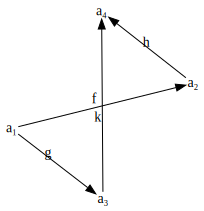

In [3]:
to_graphviz(P)

It will be convenient to program with our preorders based on the Hasse Diagram
represent as a labeled graph so we convert the Presentation{Schema, Symbol} into a FreeDigram.
FreeDiagrams are implemented as an ACSet which you can think of as an in-memory database.
ACSets are a key feature of Catlab that allow you to represent many data structures in a
common framework.

In [4]:
g = FreeDiagram(P)

ACSet with elements V = 1:4, E = 1:4
┌───┬────┐
│ V │ ob │
├───┼────┤
│ 1 │ a₁ │
│ 2 │ a₂ │
│ 3 │ a₃ │
│ 4 │ a₄ │
└───┴────┘
┌───┬─────┬─────┬─────┐
│ E │ src │ tgt │ hom │
├───┼─────┼─────┼─────┤
│ 1 │   1 │   2 │   f │
│ 2 │   1 │   3 │   g │
│ 3 │   2 │   4 │   h │
│ 4 │   3 │   4 │   k │
└───┴─────┴─────┴─────┘

To give ourselves a graph-like API for Hasse Diagrams, we define parents and children.

In [5]:
parents(g, y::Int) = subpart(g, incident(g, y, :tgt), :src)
children(g, x::Int) = subpart(g, incident(g, x, :src), :tgt)

children (generic function with 1 method)

We can compute upsets/downsets with breadth first search.

In [6]:
function bfs(g, x::Int, f=children)
  explored = falses(nparts(g, :V))
  explored[x] = 1
  q = Queue{Int}()
  enqueue!(q, x)
  while !isempty(q)
    v = dequeue!(q)
    S = f(g,v)
    map(filter(s -> !explored[s], S)) do s
      enqueue!(q, s)
    end
    explored[S] .= true
  end
  return findall(explored)
end

bfs (generic function with 2 methods)

The upset of a preorder element is all the elements that come after it in the preorder.

In [7]:
upset(g,x) = bfs(g,x,children)

upset (generic function with 1 method)

The downset is the dual notion, which we compute by reversing the role of children and parents.

In [8]:
downset(g,x) = bfs(g,x,parents)

upset(g, 1)

4-element Vector{Int64}:
 1
 2
 3
 4

We can use upsets to define the less than or equal two relation implied by any Hasse Diagram

In [9]:
function leq(g::FreeDiagram, x::Int, y::Int)
  return y in upset(g, x)
end

leq (generic function with 1 method)

### Exercise 1
Define a more efficient algorithm for checking whether two elements satisfy the leq relation.

Multiple dispatch allows us to overload the leq function with another method for symbols.

In [10]:
function leq(g::FreeDiagram, x::Symbol, y::Symbol)
  leq(g, incident(g, x, :ob), incident(g, y, :ob))
end

leq (generic function with 2 methods)

the meet of two elements is the largest element in the intersection of their downsets.

In [11]:
function meet(g::FreeDiagram, x::Int, y::Int)
  U = downset(g, x) ∩ downset(g,y)
  maxima(g, U)
  return maximum(g, U)
end

function meet(g::FreeDiagram, x, y)
  meet(g, incident(g, x, :ob)[1], incident(g, y, :ob)[1])
end

meet (generic function with 2 methods)

assuming that D is a downset, the maxima are those elements whose children are disjoint from D.

In [12]:
function maxima(g::FreeDiagram, D::Vector{Int})
  X = Set(D)
  M = filter(D) do x
    Pₓ = children(g, x) ∩ X
    length(Pₓ) == 0
  end
  return M
end

function hastop(g::FreeDiagram, xs::Vector{Int})
  length(maxima(g, xs)) == 1
end

function maximum(g::FreeDiagram, xs::Vector{Int})
  m = maxima(g, xs::Vector{Int})
  if length(m) == 1
    return m[1]
  end
  if length(m) > 1
    all_iso = all(m) do a
      Uₐ = downset(g, a)
      a_le_allb = all(m) do b
        b in Uₐ
      end
      return a_le_allb
    end
    if all_iso
      return  m[1]
    end
  end
  return nothing
end

maximum (generic function with 1 method)

From the definition of minimum, you can see that when you want to do many leq queries
in sequence, you can reuse the upsets that you compute with bfs. This is a place where
mathematical abstractions don't work well with the operational needs of computer programming.
In a mathematical definition you can define x ≤ y as y ∈ upset(x), but in programming, that is
inefficient when you want to check a property like for all y in Y, x ≤ y. Programming requires
you to reason about not only the correctness of the code, but also the performance. Much of the
complexity of software engineering comes from the fact that computational performance requires
the programmers to break down their clean abstractions to optimize the code.

### Exercise 2
If you wanted to perform many x ≤ y queries in a loop, you might want to
precompute the matrix L where L[i,j] = 1 if and only if i ≤ j in the preorder P.
Implement an algorithm that performs this computation in O(V⋅E) time where V is the number of
elements in P and E is the number of edges in the corresponding FreeDiagram.

## Testing it out

Let's make sure we get the answers that we expect.

In [13]:
using Test
@testset "Upsets" begin
  @test upset(g, 3) == [3,4]
  @test upset(g, 2) == [2,4]
  @test upset(g, 1) == [1,2,3,4]
  @test upset(g, 4) == [4]
end
@testset "Downsets" begin
  @test downset(g, 3) == [1,3]
  @test downset(g, 2) == [1,2]
  @test downset(g, 4) == [1,2,3,4]
  @test downset(g, 1) == [1]
end

@testset "Meets" begin
  @test meet(g, 2,3) == 1
  @test meet(g, 1,2) == 1
  @test meet(g, 3,4) == 3
  @test meet(g, 1, 4) == 1
  @test meet(g, 1, 1) == 1
  @test meet(g, 2, 2) == 2
end

Test Summary: | Pass  Total
Upsets        |    4      4
Test Summary: | Pass  Total
Downsets      |    4      4
Test Summary: | Pass  Total
Meets         |    6      6


Test.DefaultTestSet("Meets", Any[], 6, false, false)

## Another Example:

In [14]:
@present P(FreeSchema) begin
  (a₁,a₂,a₃,a₄, a₅)::Ob
  f::Hom(a₁, a₂)
  g::Hom(a₁, a₃)
  h::Hom(a₂, a₄)
  k::Hom(a₃, a₄)
  l::Hom(a₅, a₂)
end

Presentation{Schema, Symbol}(Catlab.Theories.FreeSchema, (Ob = Catlab.Theories.FreeSchema.Ob{:generator}[a₁, a₂, a₃, a₄, a₅], Hom = Catlab.Theories.FreeSchema.Hom{:generator}[f, g, h, k, l], AttrType = Catlab.Theories.FreeSchema.AttrType{:generator}[], Attr = Catlab.Theories.FreeSchema.Attr{:generator}[]), Dict(:a₃ => (:Ob => 3), :f => (:Hom => 1), :l => (:Hom => 5), :k => (:Hom => 4), :a₄ => (:Ob => 4), :a₁ => (:Ob => 1), :a₂ => (:Ob => 2), :g => (:Hom => 2), :h => (:Hom => 3), :a₅ => (:Ob => 5)…), Pair[])

Which can be viewed as a picture:

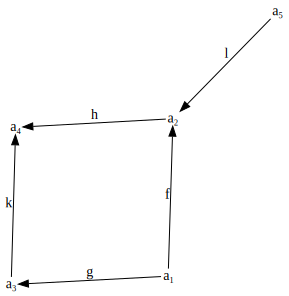

In [15]:
to_graphviz(P)

Or, as tables:

In [16]:
g = FreeDiagram(P)

ACSet with elements V = 1:5, E = 1:5
┌───┬────┐
│ V │ ob │
├───┼────┤
│ 1 │ a₁ │
│ 2 │ a₂ │
│ 3 │ a₃ │
│ 4 │ a₄ │
│ 5 │ a₅ │
└───┴────┘
┌───┬─────┬─────┬─────┐
│ E │ src │ tgt │ hom │
├───┼─────┼─────┼─────┤
│ 1 │   1 │   2 │   f │
│ 2 │   1 │   3 │   g │
│ 3 │   2 │   4 │   h │
│ 4 │   3 │   4 │   k │
│ 5 │   5 │   2 │   l │
└───┴─────┴─────┴─────┘

### Test suite

In [17]:
@testset "meets2" begin
  @test meet(g, 2,3) == 1
  @test meet(g, 1,2) == 1
  @test meet(g, 3,4) == 3
  @test meet(g, 1, 4) == 1
  @test meet(g, 1, 1) == 1
  @test meet(g, 2, 2) == 2
  @test meet(g, 3, 5) == nothing
  @test meet(g, 2, 5) == 5
end

Test Summary: | Pass  Total
meets2        |    8      8


Test.DefaultTestSet("meets2", Any[], 8, false, false)

### Exercise 3
Make bigger preorders to test corner cases in the above code.
If you find an example that breaks these implementations, please report it.

### Exercise 4
Implement the dual constructions for joins.